In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# import the functions
from numpy import dot
import torch.nn as nn
from sklearn import metrics
from numpy.linalg import norm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import mask as Mask
from torch_geometric.utils import to_networkx
from torch_geometric.nn.models import Node2Vec
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

c:\Portable\ProgramsPortable\Anaconda\envs\graphml\Lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Portable\ProgramsPortable\Anaconda\envs\graphml\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
import pandas as pd

# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load the JSON file
df = pd.read_json('./events/events_Germany.json')

# Display first 10 rows
print(df.head(10))

   eventId subEventName                          tags  playerId  \
0        8  Simple pass                [{'id': 1801}]     15231   
1        8  Simple pass                [{'id': 1801}]     14786   
2        8  Simple pass                [{'id': 1801}]     14803   
3        8  Simple pass                [{'id': 1801}]     14768   
4        8  Simple pass                [{'id': 1801}]     14803   
5        8  Simple pass                [{'id': 1801}]     40657   
6        8  Simple pass                [{'id': 1801}]     14803   
7        8  Simple pass                [{'id': 1802}]     40657   
8        8  Simple pass  [{'id': 1401}, {'id': 1801}]     15811   
9        8  Simple pass                [{'id': 1801}]     14732   

                                  positions  matchId eventName  teamId  \
0  [{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]  2516739      Pass    2446   
1  [{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]  2516739      Pass    2446   
2   [{'y': 22, 'x': 22}, {'y': 46, 'x': 

In [3]:
import pandas as pd

df = pd.read_json('./events/events_Germany.json')

# Save full dataset to CSV
df.to_csv('events_Germany.csv', index=False)

print(f"Full CSV created with {len(df)} rows")

Full CSV created with 519407 rows


In [4]:
def extract_team_match_events(events_df, team_id, match_id):
    """
    Extract all events for a specific team in a specific match
    
    Args:
        events_df: Full events DataFrame
        team_id: ID of the team (e.g., 2446)
        match_id: ID of the match (e.g., 2516739)
    
    Returns:
        DataFrame with filtered events
    """
    # Filter for this match and this team
    team_match_events = events_df[
        (events_df['matchId'] == match_id) & 
        (events_df['teamId'] == team_id)
    ].copy()
    
    # Sort by time (critical for transition extraction!)
    team_match_events = team_match_events.sort_values('eventSec').reset_index(drop=True)
    
    print(f"Team {team_id} in Match {match_id}: {len(team_match_events)} events")
    
    return team_match_events

In [5]:
def save_team_match_events(team_match_events, team_id, match_id, output_dir='processed_events'):
    """
    Save team-match events to file for later processing
    
    Args:
        team_match_events: Filtered DataFrame
        team_id: Team ID
        match_id: Match ID  
        output_dir: Directory to save files
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create meaningful filename
    filename = f"team_{team_id}_match_{match_id}.csv"
    filepath = os.path.join(output_dir, filename)
    
    # Save to CSV (or pickle for faster loading)
    team_match_events.to_csv(filepath, index=False)
    # OR: team_match_events.to_pickle(filepath.replace('.csv', '.pkl'))
    
    print(f"Saved to: {filepath}")
    return filepath

In [6]:
team_id = 2446  # Example team ID
match_id = 2516739  # Example match ID

# Extract events for the specific team and match
team_match_events = extract_team_match_events(df, team_id, match_id)

# Save the extracted events to a file
save_team_match_events(team_match_events, team_id, match_id)


Team 2446 in Match 2516739: 830 events
Saved to: processed_events\team_2446_match_2516739.csv


'processed_events\\team_2446_match_2516739.csv'

In [7]:
unique_players = team_match_events['playerId'].nunique()
print(f"Total unique players: {unique_players}")

Total unique players: 15


In [18]:
import numpy as np
import pandas as pd
from typing import Tuple, List, Optional

class FootballFieldDiscretizer:
    """
    Discretize football field with custom width/height segments
    
    Width segments (5 cols): 21, 16, 26, 16, 21 (sum=100)
    Height segments (8 rows): 6, 10, 17, 17, 17, 17, 10, 6 (sum=100)
    
    Zone numbering (40 zones + 1 outside):
    - Zones 0-39: Grid zones (row-major order)
    - Zone 40: Outside/out-of-bounds
    """
    
    def __init__(self):
        # Define segments
        self.width_segments = [21, 16, 26, 16, 21]  # 5 columns
        self.height_segments = [6, 10, 17, 17, 17, 17, 10, 6]  # 8 rows
        
        self.n_rows = len(self.height_segments)
        self.n_cols = len(self.width_segments)
        self.n_zones = self.n_rows * self.n_cols  # 40 zones
        self.outside_zone_id = self.n_zones  # Zone 40
        
        # Precompute cumulative boundaries for fast lookup
        self.width_boundaries = np.cumsum([0] + self.width_segments)
        self.height_boundaries = np.cumsum([0] + self.height_segments)
        
        # Tactical zone names (optional, for interpretability)
        self.zone_names = self._create_zone_names()
    
    def _create_zone_names(self) -> dict:
        """
        Create human-readable names for zones based on tactical significance
        """
        # Column names (width)
        col_names = ['LEFT_WING', 'LEFT_HALF', 'CENTER', 'RIGHT_HALF', 'RIGHT_WING']
        
        # Row names (height) - from defensive to attacking
        row_names = [
            'DEF_BOX',        # Row 0: Defensive 6-yard area
            'DEF_PENALTY',    # Row 1: Defensive penalty area
            'DEF_THIRD_DEEP', # Row 2: Deep defensive third
            'DEF_THIRD',      # Row 3: Defensive third
            'MID_THIRD_DEF',  # Row 4: Middle third (defensive half)
            'MID_THIRD_ATT',  # Row 5: Middle third (attacking half)
            'ATT_THIRD',      # Row 6: Attacking third
            'ATT_PENALTY',    # Row 7: Attacking penalty area
        ]
        
        zone_names = {}
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                zone_id = self.rowcol_to_id(row, col)
                zone_names[zone_id] = f"{row_names[row]}_{col_names[col]}"
        
        zone_names[self.outside_zone_id] = 'OUTSIDE'
        
        return zone_names
    
    def coords_to_zone(self, x: float, y: float) -> Tuple[int, Tuple[int, int]]:
        """
        Convert (x, y) coordinates to zone ID and (row, col)
        
        Args:
            x: X-coordinate (0-100, width/goal line)
            y: Y-coordinate (0-100, height/length)
        
        Returns:
            (zone_id, (row, col))
        """
        # Handle outside zone
        # if x < 0 or x > 100 or y < 0 or y > 100:
        #     return self.outside_zone_id, (-1, -1)
        
        # Special case: exactly at boundary (100, 100)
        if x == 100 and y == 100:
            return self.outside_zone_id, (-1, -1)
        
        # Find column (x-axis, width)
        col = np.searchsorted(self.width_boundaries[1:], x, side='right')
        col = min(col, self.n_cols - 1)
        
        # Find row (y-axis, height)
        row = np.searchsorted(self.height_boundaries[1:], y, side='right')
        row = min(row, self.n_rows - 1)
        
        # Convert to zone ID
        zone_id = self.rowcol_to_id(row, col)
        
        return zone_id, (row, col)
    
    def rowcol_to_id(self, row: int, col: int) -> int:
        """
        Convert (row, col) to zone ID using row-major order
        
        Example:
            (0, 0) -> 0
            (0, 1) -> 1
            (1, 0) -> 5
        """
        if row < 0 or row >= self.n_rows or col < 0 or col >= self.n_cols:
            return self.outside_zone_id
        return row * self.n_cols + col
    
    def id_to_rowcol(self, zone_id: int) -> Tuple[int, int]:
        """
        Convert zone ID to (row, col)
        
        Example:
            0 -> (0, 0)
            5 -> (1, 0)
            40 -> (-1, -1) [outside]
        """
        if zone_id == self.outside_zone_id:
            return (-1, -1)
        
        row = zone_id // self.n_cols
        col = zone_id % self.n_cols
        return (row, col)
    
    def get_zone_center(self, zone_id: int) -> Tuple[float, float]:
        """
        Get center coordinates of a zone
        
        Returns:
            (x_center, y_center) in 0-100 scale
        """
        if zone_id == self.outside_zone_id:
            return (100.0, 100.0)
        
        row, col = self.id_to_rowcol(zone_id)
        
        x_start = self.width_boundaries[col]
        x_end = self.width_boundaries[col + 1]
        x_center = (x_start + x_end) / 2
        
        y_start = self.height_boundaries[row]
        y_end = self.height_boundaries[row + 1]
        y_center = (y_start + y_end) / 2
        
        return (x_center, y_center)
    
    def get_zone_bounds(self, zone_id: int) -> Tuple[float, float, float, float]:
        """
        Get zone boundaries
        
        Returns:
            (x_min, x_max, y_min, y_max)
        """
        if zone_id == self.outside_zone_id:
            return (100.0, 100.0, 100.0, 100.0)
        
        row, col = self.id_to_rowcol(zone_id)
        
        x_min = self.width_boundaries[col]
        x_max = self.width_boundaries[col + 1]
        y_min = self.height_boundaries[row]
        y_max = self.height_boundaries[row + 1]
        
        return (x_min, x_max, y_min, y_max)
    
    def get_zone_name(self, zone_id: int) -> str:
        """Get human-readable zone name"""
        return self.zone_names.get(zone_id, f"ZONE_{zone_id}")
    
    def discretize_events(self, events_df: pd.DataFrame) -> pd.DataFrame:
        """
        Add zone information to events DataFrame
        
        Assumes 'positions' column contains coordinates
        Format: [{'y': Y, 'x': X}, ...] or similar
        
        Returns:
            DataFrame with added columns: zone_id, zone_row, zone_col, zone_name
        """
        events_df = events_df.copy()
        
        # Extract coordinates
        def extract_coords(positions):
            """Extract first coordinate from positions"""
            # Handle None/NaN
            if positions is None:
                return None, None
            
            # Check if it's a scalar NaN (from pandas)
            try:
                if pd.isna(positions):
                    return None, None
            except (ValueError, TypeError):
                # positions is an array/list, not a scalar
                pass
            
            # Handle string representation (if data is stored as string)
            if isinstance(positions, str):
                try:
                    import ast
                    positions = ast.literal_eval(positions)
                except:
                    return None, None
            
            # Handle list/array
            if isinstance(positions, (list, np.ndarray)):
                if len(positions) == 0:
                    return None, None
                
                # Get first position
                pos = positions[0]
                
                # Handle dict format: {'x': ..., 'y': ...}
                if isinstance(pos, dict):
                    return pos.get('x'), pos.get('y')
                
                # Handle tuple/list format: (x, y)
                if isinstance(pos, (tuple, list)) and len(pos) >= 2:
                    return pos[0], pos[1]
            
            return None, None
        
        # Apply coordinate extraction
        coords = events_df['positions'].apply(extract_coords)
        events_df['x'] = coords.apply(lambda c: c[0] if c[0] is not None else 100)
        events_df['y'] = coords.apply(lambda c: c[1] if c[1] is not None else 100)
        
        # Map to zones
        zone_info = events_df.apply(
            lambda row: self.coords_to_zone(row['x'], row['y']), 
            axis=1
        )
        
        events_df['zone_id'] = zone_info.apply(lambda z: z[0])
        events_df['zone_row'] = zone_info.apply(lambda z: z[1][0])
        events_df['zone_col'] = zone_info.apply(lambda z: z[1][1])
        events_df['zone_name'] = events_df['zone_id'].apply(self.get_zone_name)
        
        return events_df


class EventQueryEngine:
    """
    Query engine for zone-based event retrieval
    """
    
    def __init__(self, events_df: pd.DataFrame, discretizer: FootballFieldDiscretizer):
        """
        Args:
            events_df: DataFrame with zone_id column (from discretizer)
            discretizer: FootballFieldDiscretizer instance
        """
        self.events_df = events_df
        self.discretizer = discretizer
        
        # Build transition graph for fast queries
        self._build_transition_index()
    
    def _build_transition_index(self):
        """
        Precompute transitions for fast queries
        Creates index of consecutive events within same possession
        """
        # Sort by match, team, and time
        sorted_events = self.events_df.sort_values(
            ['matchId', 'teamId', 'eventSec']
        ).reset_index(drop=True)
        
        # Identify transitions (consecutive events by same team in same match)
        sorted_events['next_zone'] = sorted_events.groupby(
            ['matchId', 'teamId']
        )['zone_id'].shift(-1)
        
        sorted_events['next_eventId'] = sorted_events.groupby(
            ['matchId', 'teamId']
        )['eventId'].shift(-1)
        
        # Filter out transitions to same zone (no movement)
        self.transitions_df = sorted_events[
            sorted_events['zone_id'] != sorted_events['next_zone']
        ].copy()
        
        self.transitions_df = self.transitions_df.dropna(subset=['next_zone'])
        self.transitions_df['next_zone'] = self.transitions_df['next_zone'].astype(int)
    
    def get_events_from_zone(self, zone_id: int, 
                            team_id: Optional[int] = None,
                            match_id: Optional[int] = None) -> pd.DataFrame:
        """
        Retrieve all events starting from a given zone
        
        Args:
            zone_id: Starting zone ID
            team_id: Optional filter by team
            match_id: Optional filter by match
        
        Returns:
            DataFrame of events
        """
        query = self.events_df['zone_id'] == zone_id
        
        if team_id is not None:
            query &= self.events_df['teamId'] == team_id
        
        if match_id is not None:
            query &= self.events_df['matchId'] == match_id
        
        return self.events_df[query].copy()
    
    def get_transitions_from_zone(self, zone_id: int,
                                  team_id: Optional[int] = None,
                                  match_id: Optional[int] = None) -> pd.DataFrame:
        """
        Retrieve all transitions (movements) starting from a given zone
        
        Returns events that transition FROM this zone TO another zone
        
        Args:
            zone_id: Starting zone ID
            team_id: Optional filter by team
            match_id: Optional filter by match
        
        Returns:
            DataFrame with columns including: zone_id (from), next_zone (to), ...
        """
        query = self.transitions_df['zone_id'] == zone_id
        
        if team_id is not None:
            query &= self.transitions_df['teamId'] == team_id
        
        if match_id is not None:
            query &= self.transitions_df['matchId'] == match_id
        
        return self.transitions_df[query].copy()
    
    
    def get_transitions_to_zone(self, zone_id: int,
                           team_id: Optional[int] = None,
                           match_id: Optional[int] = None) -> pd.DataFrame:
        """
        Retrieve all transitions ENDING at a given zone
        
        Returns events that transition TO this zone FROM another zone
        
        Args:
            zone_id: Destination zone ID
            team_id: Optional filter by team
            match_id: Optional filter by match
        
        Returns:
            DataFrame with transitions ending at zone_id
        """
        query = self.transitions_df['next_zone'] == zone_id
        
        if team_id is not None:
            query &= self.transitions_df['teamId'] == team_id
        
        if match_id is not None:
            query &= self.transitions_df['matchId'] == match_id
        
        return self.transitions_df[query].copy()
    
    def get_transitions_between_zones(self, from_zone_id: int, to_zone_id: int,
                                     team_id: Optional[int] = None,
                                     match_id: Optional[int] = None) -> pd.DataFrame:
        """
        Retrieve all transitions between two specific zones
        
        Args:
            from_zone_id: Starting zone ID
            to_zone_id: Ending zone ID
            team_id: Optional filter by team
            match_id: Optional filter by match
        
        Returns:
            DataFrame of transition events
        """
        query = (
            (self.transitions_df['zone_id'] == from_zone_id) &
            (self.transitions_df['next_zone'] == to_zone_id)
        )
        
        if team_id is not None:
            query &= self.transitions_df['teamId'] == team_id
        
        if match_id is not None:
            query &= self.transitions_df['matchId'] == match_id
        
        return self.transitions_df[query].copy()
    
    def get_zone_statistics(self, zone_id: int) -> dict:
        """
        Get statistics for a specific zone
        
        Returns:
            Dictionary with zone stats
        """
        zone_events = self.get_events_from_zone(zone_id)
        zone_transitions = self.get_transitions_from_zone(zone_id)
        
        if len(zone_events) == 0:
            return {
                'zone_id': zone_id,
                'zone_name': self.discretizer.get_zone_name(zone_id),
                'total_events': 0,
                'unique_players': 0,
                'transitions_out': 0
            }
        
        return {
            'zone_id': zone_id,
            'zone_name': self.discretizer.get_zone_name(zone_id),
            'total_events': len(zone_events),
            'unique_players': zone_events['playerId'].nunique(),
            'unique_teams': zone_events['teamId'].nunique(),
            'unique_matches': zone_events['matchId'].nunique(),
            'transitions_out': len(zone_transitions),
            'most_common_next_zone': zone_transitions['next_zone'].mode()[0] if len(zone_transitions) > 0 else None,
            'event_types': zone_events['eventName'].value_counts().to_dict()
        }
    
    def get_transition_matrix(self, team_id: Optional[int] = None,
                             match_id: Optional[int] = None,
                             normalize: bool = False) -> np.ndarray:
        """
        Build transition matrix between zones
        
        Args:
            team_id: Optional filter by team
            match_id: Optional filter by match
            normalize: If True, normalize by row (transition probabilities)
        
        Returns:
            Matrix of shape (n_zones+1, n_zones+1) with transition counts
        """
        n_total = self.discretizer.n_zones + 1  # Include outside zone
        matrix = np.zeros((n_total, n_total))
        
        # Filter transitions
        transitions = self.transitions_df.copy()
        if team_id is not None:
            transitions = transitions[transitions['teamId'] == team_id]
        if match_id is not None:
            transitions = transitions[transitions['matchId'] == match_id]
        
        # Build matrix
        for _, row in transitions.iterrows():
            from_zone = int(row['zone_id'])
            to_zone = int(row['next_zone'])
            matrix[from_zone, to_zone] += 1
        
        if normalize:
            # Normalize by row (each row sums to 1)
            row_sums = matrix.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1  # Avoid division by zero
            matrix = matrix / row_sums
        
        return matrix

In [12]:
discretizer = FootballFieldDiscretizer()
events_with_zones = discretizer.discretize_events(team_match_events)

In [20]:
print("Sample discretized events:")
print(events_with_zones[['eventId', 'x', 'y', 'zone_id', 'zone_name']].head(10))

# ============================================
# Example 2: Query Events from Specific Zone
# ============================================

# Initialize query engine
query_engine = EventQueryEngine(events_with_zones, discretizer)

# Get all events from attacking penalty area center (zone 37)
att_penalty_center = query_engine.get_events_from_zone(zone_id=37)
print(f"\nEvents in attacking penalty center: {len(att_penalty_center)}")

# Get events from specific team in specific zone
team_2446_def_zone = query_engine.get_events_from_zone(
    zone_id=0, 
    team_id=2446
)
print(f"Team 2446 events in defensive box: {len(team_2446_def_zone)}")

# ============================================
# Example 3: Query Transitions
# ============================================

# Get all transitions starting from center midfield (zone 22)
transitions_from_center = query_engine.get_transitions_from_zone(zone_id=22)
print(f"\nTransitions from center midfield: {len(transitions_from_center)}")

# Where does the ball usually go?
next_zones = transitions_from_center['next_zone'].value_counts().head(5)
print("\nTop 5 destination zones from center midfield:")
for zone_id, count in next_zones.items():
    print(f"  {discretizer.get_zone_name(zone_id)}: {count} transitions")

# ============================================
# Example 4: Transitions Between Specific Zones
# ============================================

# Get transitions from defensive third to attacking third (direct play)
# Zone 15 (DEF_THIRD_CENTER) -> Zone 32 (ATT_THIRD_DEF_CENTER)
direct_passes = query_engine.get_transitions_between_zones(
    from_zone_id=15, 
    to_zone_id=32
)
print(f"\nDirect passes from defense to attack: {len(direct_passes)}")

# Analyze these transitions
if len(direct_passes) > 0:
    print(f"Event types: {direct_passes['eventName'].value_counts().to_dict()}")
    print(f"Success rate: {(direct_passes['subEventName'] != 'Throw in').mean():.2%}")

# ============================================
# Example 5: Zone Statistics
# ============================================

# Get comprehensive stats for a zone
zone_stats = query_engine.get_zone_statistics(zone_id=22)  # Center midfield

print(f"\n{'='*50}")
print(f"Statistics for {zone_stats['zone_name']} (Zone {zone_stats['zone_id']})")
print(f"{'='*50}")
print(f"Total events: {zone_stats['total_events']}")
print(f"Unique players: {zone_stats['unique_players']}")
print(f"Transitions out: {zone_stats['transitions_out']}")
print(f"\nEvent types:")
for event_type, count in list(zone_stats['event_types'].items())[:5]:
    print(f"  {event_type}: {count}")

# ============================================
# Example 6: Transition Matrix
# ============================================

# Build transition matrix for specific team
team_id = 2446
match_id = 2516739

transition_matrix = query_engine.get_transition_matrix(
    team_id=team_id,
    match_id=match_id,
    normalize=True  # Get probabilities
)

print(f"\nTransition matrix shape: {transition_matrix.shape}")
print(f"Sum of probabilities from zone 22: {transition_matrix[22].sum():.2f}")

# Find most common transitions
from_zone = 22  # Center midfield
top_destinations = np.argsort(transition_matrix[from_zone])[-5:][::-1]

print(f"\nMost likely destinations from zone {from_zone}:")
for dest_zone in top_destinations:
    prob = transition_matrix[from_zone, dest_zone]
    if prob > 0:
        print(f"  -> Zone {dest_zone} ({discretizer.get_zone_name(dest_zone)}): {prob:.1%}")

# ============================================
# Example 7: Visualize Zone Layout
# ============================================

def print_zone_grid():
    """Print zone IDs in grid layout"""
    print("\nZone ID Layout (attacking left to right):")
    print("=" * 60)
    
    for row in range(discretizer.n_rows):
        row_zones = []
        for col in range(discretizer.n_cols):
            zone_id = discretizer.rowcol_to_id(row, col)
            row_zones.append(f"{zone_id:2d}")
        print(f"Row {row}: " + " | ".join(row_zones))
    
    print(f"\nOutside zone: {discretizer.outside_zone_id}")
    print("=" * 60)

print_zone_grid()

# ============================================
# Example 8: Team-Specific Analysis
# ============================================

def analyze_team_zones(team_id, match_id, query_engine):
    """Analyze which zones a team uses most"""
    
    team_events = query_engine.events_df[
        (query_engine.events_df['teamId'] == team_id) &
        (query_engine.events_df['matchId'] == match_id)
    ]
    
    zone_usage = team_events['zone_id'].value_counts().head(10)
    
    print(f"\nTeam {team_id} in Match {match_id} - Top 10 Zones:")
    for zone_id, count in zone_usage.items():
        zone_name = discretizer.get_zone_name(zone_id)
        pct = count / len(team_events) * 100
        print(f"  {zone_name:30s} (Zone {zone_id:2d}): {count:4d} events ({pct:5.1f}%)")

analyze_team_zones(2446, 2516739, query_engine)

Sample discretized events:
   eventId   x   y  zone_id                  zone_name
0        8  50  50       22       MID_THIRD_DEF_CENTER
1        8  50  48       17           DEF_THIRD_CENTER
2        8  22  22       11   DEF_THIRD_DEEP_LEFT_HALF
3        8   6  46       15        DEF_THIRD_LEFT_WING
4        8  20  10        5      DEF_PENALTY_LEFT_WING
5        8  59  10        7         DEF_PENALTY_CENTER
6        8  27   4        1          DEF_BOX_LEFT_HALF
7        8  74   5        3         DEF_BOX_RIGHT_HALF
8        8  18   1        0          DEF_BOX_LEFT_WING
9        8  77  19       13  DEF_THIRD_DEEP_RIGHT_HALF

Events in attacking penalty center: 23
Team 2446 events in defensive box: 8

Transitions from center midfield: 31

Top 5 destination zones from center midfield:
  DEF_THIRD_CENTER: 3 transitions
  OUTSIDE: 2 transitions
  MID_THIRD_ATT_RIGHT_HALF: 2 transitions
  DEF_THIRD_DEEP_RIGHT_WING: 2 transitions
  MID_THIRD_DEF_RIGHT_HALF: 2 transitions

Direct passes from 

In [17]:
# Get all transitions starting from outside (zone 40)
transitions_from_outside = query_engine.get_transitions_from_zone(zone_id=40)
print(f"\nTransitions from outside: {len(transitions_from_outside)}")
# Print all transitions
print(transitions_from_outside)
# Where does the ball usually go?
next_zones = transitions_from_outside['next_zone'].value_counts().head(5)
print("\nTop 5 destination zones from outside:")
for zone_id, count in next_zones.items():
    print(f"  {discretizer.get_zone_name(zone_id)}: {count} transitions")


Transitions from outside: 59
     eventId             subEventName  \
17         3                   Corner   
27         5    Ball out of the field   
76         5    Ball out of the field   
83         3                Goal kick   
92         3                 Throw in   
105        5    Ball out of the field   
112        9             Save attempt   
126        5    Ball out of the field   
131        5    Ball out of the field   
133        3                 Throw in   
135        5    Ball out of the field   
155        9                 Reflexes   
188        9                 Reflexes   
209        5    Ball out of the field   
239        5    Ball out of the field   
243        5    Ball out of the field   
260        5    Ball out of the field   
263        5    Ball out of the field   
267        3                 Throw in   
293        5    Ball out of the field   
299        5    Ball out of the field   
311        3                Goal kick   
313        9               

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_pitch_zones(discretizer, figsize=(14, 10), highlight_zones=None):
    """
    Plot football pitch with zone grid and IDs
    
    Args:
        discretizer: FootballFieldDiscretizer instance
        figsize: Figure size (width, height)
        highlight_zones: List of zone IDs to highlight (optional)
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor='#1a1a1a')
    ax.set_facecolor('#2d5016')  # Football pitch green
    
    # Pitch dimensions (scaled to match 0-100 coordinates)
    pitch_length = 100
    pitch_width = 100
    
    # Draw pitch outline
    pitch_rect = patches.Rectangle((0, 0), pitch_length, pitch_width,
                                   linewidth=3, edgecolor='white', 
                                   facecolor='#2d5016', zorder=1)
    ax.add_patch(pitch_rect)
    
    # Draw halfway line
    ax.plot([50, 50], [0, 100], color='white', linewidth=2, zorder=2)
    
    # Draw center circle (radius ~9.15m on 105m pitch = ~8.7 units)
    center_circle = patches.Circle((50, 50), 8.7, linewidth=2,
                                   edgecolor='white', facecolor='none', zorder=2)
    ax.add_patch(center_circle)
    ax.plot(50, 50, 'o', color='white', markersize=4, zorder=2)
    
    # Draw penalty areas (16.5m / 105m * 100 = ~15.7 units deep)
    # Width: 40.32m / 68m * 100 = ~59.3 units, centered at 50
    penalty_width = 59.3
    penalty_depth = 15.7
    penalty_margin = (100 - penalty_width) / 2
    
    # Left penalty area
    left_penalty = patches.Rectangle((0, penalty_margin), penalty_depth, penalty_width,
                                    linewidth=2, edgecolor='white', 
                                    facecolor='none', zorder=2)
    ax.add_patch(left_penalty)
    
    # Right penalty area
    right_penalty = patches.Rectangle((100-penalty_depth, penalty_margin), 
                                     penalty_depth, penalty_width,
                                     linewidth=2, edgecolor='white', 
                                     facecolor='none', zorder=2)
    ax.add_patch(right_penalty)
    
    # Draw goal areas (5.5m / 105m * 100 = ~5.2 units deep)
    goal_width = 26.9
    goal_depth = 5.2
    goal_margin = (100 - goal_width) / 2
    
    # Left goal area
    left_goal = patches.Rectangle((0, goal_margin), goal_depth, goal_width,
                                 linewidth=2, edgecolor='white', 
                                 facecolor='none', zorder=2)
    ax.add_patch(left_goal)
    
    # Right goal area
    right_goal = patches.Rectangle((100-goal_depth, goal_margin), 
                                  goal_depth, goal_width,
                                  linewidth=2, edgecolor='white', 
                                  facecolor='none', zorder=2)
    ax.add_patch(right_goal)
    
    # Draw penalty spots
    ax.plot(11, 50, 'o', color='white', markersize=4, zorder=2)
    ax.plot(89, 50, 'o', color='white', markersize=4, zorder=2)
    
    # Draw corner arcs
    corner_radius = 1.5
    for x, y in [(0, 0), (0, 100), (100, 0), (100, 100)]:
        if x == 0 and y == 0:
            arc = patches.Arc((x, y), corner_radius*2, corner_radius*2, 
                            angle=0, theta1=0, theta2=90, 
                            linewidth=2, edgecolor='white', zorder=2)
        elif x == 0 and y == 100:
            arc = patches.Arc((x, y), corner_radius*2, corner_radius*2, 
                            angle=0, theta1=270, theta2=360, 
                            linewidth=2, edgecolor='white', zorder=2)
        elif x == 100 and y == 0:
            arc = patches.Arc((x, y), corner_radius*2, corner_radius*2, 
                            angle=0, theta1=90, theta2=180, 
                            linewidth=2, edgecolor='white', zorder=2)
        else:  # (100, 100)
            arc = patches.Arc((x, y), corner_radius*2, corner_radius*2, 
                            angle=0, theta1=180, theta2=270, 
                            linewidth=2, edgecolor='white', zorder=2)
        ax.add_patch(arc)
    
    # Draw zone grid
    for row in range(discretizer.n_rows):
        for col in range(discretizer.n_cols):
            zone_id = discretizer.rowcol_to_id(row, col)
            x_min, x_max, y_min, y_max = discretizer.get_zone_bounds(zone_id)
            
            # Determine zone color
            if highlight_zones and zone_id in highlight_zones:
                facecolor = 'yellow'
                alpha = 0.3
                edgecolor = 'yellow'
                linewidth = 2
            else:
                facecolor = 'none'
                alpha = 0.5
                edgecolor = 'cyan'
                linewidth = 1
            
            # Draw zone rectangle
            zone_rect = patches.Rectangle((x_min, y_min), 
                                        x_max - x_min, 
                                        y_max - y_min,
                                        linewidth=linewidth, 
                                        edgecolor=edgecolor, 
                                        facecolor=facecolor,
                                        alpha=alpha,
                                        zorder=3)
            ax.add_patch(zone_rect)
            
            # Add zone ID label
            x_center, y_center = discretizer.get_zone_center(zone_id)
            
            # Background box for better readability
            bbox_props = dict(boxstyle='round,pad=0.3', 
                            facecolor='black', 
                            alpha=0.7, 
                            edgecolor='none')
            
            ax.text(x_center, y_center, str(zone_id),
                   ha='center', va='center',
                   fontsize=11, fontweight='bold',
                   color='white', bbox=bbox_props, zorder=4)
    
    # Add labels
    ax.text(50, -5, 'DEFENSIVE →', ha='center', va='top', 
           fontsize=12, color='white', fontweight='bold')
    ax.text(50, 105, '← ATTACKING', ha='center', va='bottom', 
           fontsize=12, color='white', fontweight='bold')
    
    # Add grid info
    info_text = f"Grid: {discretizer.n_cols} cols × {discretizer.n_rows} rows = {discretizer.n_zones} zones"
    ax.text(2, -3, info_text, ha='left', va='top',
           fontsize=10, color='white', style='italic')
    
    ax.set_xlim(-3, 103)
    ax.set_ylim(-8, 108)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.title('Football Pitch - Zone Grid with IDs', 
             fontsize=16, color='white', fontweight='bold', pad=20)
    plt.tight_layout()
    
    return fig, ax


def plot_zone_grid_simple(discretizer, figsize=(12, 8)):
    """
    Simplified grid visualization - just zones and IDs, no pitch markings
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    
    # Draw each zone
    for row in range(discretizer.n_rows):
        for col in range(discretizer.n_cols):
            zone_id = discretizer.rowcol_to_id(row, col)
            x_min, x_max, y_min, y_max = discretizer.get_zone_bounds(zone_id)
            
            # Alternating colors for better visibility
            if (row + col) % 2 == 0:
                facecolor = '#e8f4e8'
            else:
                facecolor = '#d4e8d4'
            
            # Draw zone
            zone_rect = patches.Rectangle((x_min, y_min), 
                                        x_max - x_min, 
                                        y_max - y_min,
                                        linewidth=2, 
                                        edgecolor='black', 
                                        facecolor=facecolor,
                                        zorder=1)
            ax.add_patch(zone_rect)
            
            # Add zone ID
            x_center, y_center = discretizer.get_zone_center(zone_id)
            zone_name = discretizer.get_zone_name(zone_id)
            
            # Zone ID (large)
            ax.text(x_center, y_center + 2, str(zone_id),
                   ha='center', va='center',
                   fontsize=16, fontweight='bold', color='black')
            
            # Zone name (small)
            ax.text(x_center, y_center - 2, zone_name.replace('_', '\n'),
                   ha='center', va='center',
                   fontsize=6, color='#555', style='italic')
    
    # Add row labels
    for row in range(discretizer.n_rows):
        y_center = (discretizer.height_boundaries[row] + 
                   discretizer.height_boundaries[row + 1]) / 2
        ax.text(-2, y_center, f'Row {row}', 
               ha='right', va='center', fontsize=10, fontweight='bold')
    
    # Add column labels
    for col in range(discretizer.n_cols):
        x_center = (discretizer.width_boundaries[col] + 
                   discretizer.width_boundaries[col + 1]) / 2
        ax.text(x_center, 102, f'Col {col}', 
               ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlim(-5, 105)
    ax.set_ylim(-2, 105)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.title('Zone Grid Layout', fontsize=14, fontweight='bold', pad=10)
    plt.tight_layout()
    
    return fig, ax


def plot_zone_heatmap(discretizer, zone_counts, figsize=(12, 8), title="Zone Activity"):
    """
    Heatmap visualization of zone activity
    
    Args:
        discretizer: FootballFieldDiscretizer instance
        zone_counts: dict or Series with {zone_id: count}
        figsize: Figure size
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Convert to dict if Series
    if hasattr(zone_counts, 'to_dict'):
        zone_counts = zone_counts.to_dict()
    
    # Normalize counts for color mapping
    max_count = max(zone_counts.values()) if zone_counts else 1
    
    # Draw zones
    for row in range(discretizer.n_rows):
        for col in range(discretizer.n_cols):
            zone_id = discretizer.rowcol_to_id(row, col)
            x_min, x_max, y_min, y_max = discretizer.get_zone_bounds(zone_id)
            
            # Get count and normalize
            count = zone_counts.get(zone_id, 0)
            intensity = count / max_count if max_count > 0 else 0
            
            # Color: white (no activity) -> red (high activity)
            color = plt.cm.Reds(intensity * 0.8 + 0.2)  # Start from light color
            
            # Draw zone
            zone_rect = patches.Rectangle((x_min, y_min), 
                                        x_max - x_min, 
                                        y_max - y_min,
                                        linewidth=1, 
                                        edgecolor='gray', 
                                        facecolor=color,
                                        zorder=1)
            ax.add_patch(zone_rect)
            
            # Add labels
            x_center, y_center = discretizer.get_zone_center(zone_id)
            
            # Zone ID
            ax.text(x_center, y_center + 1.5, str(zone_id),
                   ha='center', va='center',
                   fontsize=10, fontweight='bold', color='black')
            
            # Count
            ax.text(x_center, y_center - 1.5, str(count),
                   ha='center', va='center',
                   fontsize=9, color='black')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                               norm=plt.Normalize(vmin=0, vmax=max_count))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Event Count', rotation=270, labelpad=15)
    
    ax.set_xlim(-2, 102)
    ax.set_ylim(-2, 102)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.title(title, fontsize=14, fontweight='bold', pad=10)
    plt.tight_layout()
    
    return fig, ax

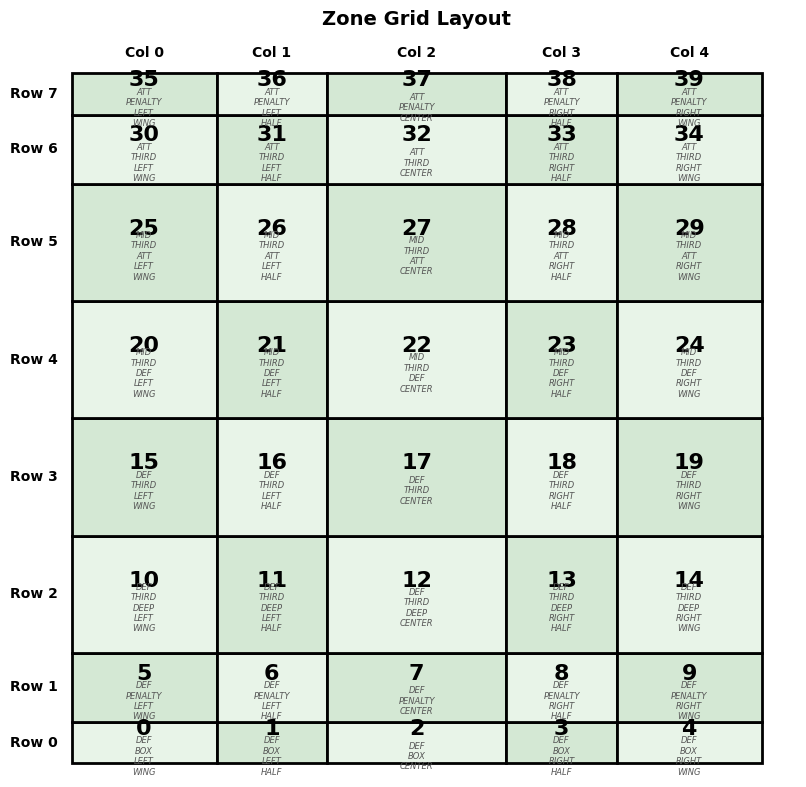

In [22]:
# Just show me the zones!
discretizer = FootballFieldDiscretizer()
plot_zone_grid_simple(discretizer)
plt.show()